## EDA

In [1]:
#importo librerias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest
from itertools import combinations

In [2]:
#defino función genérica para cargar CSV
def load_csv(path, nrows=None):
    df = pd.read_csv(path, nrows=nrows)
    return df

In [3]:
import os

#defino función genérica para cargar CSV 
def load_csv(path, nrows=None, sep=';'):
    return pd.read_csv(path, sep=sep, engine='python', encoding='utf-8', nrows=nrows)

# defino límites de trimestres 
dfs = {}
for t in range(1, 5):               
    f = f"trimestre{t}.csv"
    dfs[os.path.splitext(f)[0]] = load_csv(f)
    
# Verifico las columnas de cada dataset
for name, df in dfs.items():
    print(f"Archivo {name}: {df.columns.tolist()}")

Archivo trimestre1: ['Comunidades autónomas', 'Tipología penal', 'Periodos:', 'Total']
Archivo trimestre2: ['Comunidades autónomas', 'Tipología penal', 'Periodos:', 'Total']
Archivo trimestre3: ['Comunidades autónomas', 'Tipología penal', 'Periodos:', 'Total']
Archivo trimestre4: ['Comunidades autónomas', 'Tipología penal', 'Periodos:', 'Total']


In [ ]:
def pre_eda(df: pd.DataFrame, name: str = "df"): #una funcion pre-Eda que recibe un dataframe y lo llama df.
    rep = {} #define un diccionario donde iran guardando los resultados del preEda.
    dfc = df.copy()# se crea una copia del dataframe para no trabajar sobre el original.
    
    # Normaliza columnas
    rep["cols_original"] = list(dfc.columns)#Guarda el nombre de las columnas.Normaliza el texto.Convierte a minuscula,quita espacios,
                                            #cambia los espacios por guiones bajos y eliminia cualquier caracter raro con regex)
    dfc.columns = (
        dfc.columns.str.strip().str.lower()
        .str.replace(" ", "_", regex=True)
        .str.replace("[^0-9a-z_]", "", regex=True)
    )
    rep["cols_limpias"] = list(dfc.columns) #guarda los nombres ya limpios
    
    # === FILTRADO: QUITAR VARIACIONES Y DEJAR SOLO 2024 ===
    rep["registros_antes_filtrado"] = len(dfc)
    
    # Detectar columna de periodos
    period_col = None
    for col in dfc.columns:
        if any(k in col.lower() for k in ['period', 'fecha', 'tiempo', 'año', 'mes']):
            period_col = col
            break
    
    if period_col is not None:
        # 1. Eliminar filas con "Variación" en cualquier parte
        mask_variacion = dfc[period_col].astype(str).str.lower().str.contains('variaci', na=False)
        dfc = dfc[~mask_variacion].copy()
        # 2. Eliminar año 2023
        mask_2023 = dfc[period_col].astype(str).str.contains('2023', na=False)
        dfc = dfc[~mask_2023].copy()
        # 3. Filtrar SOLO año 2024
        mask_2024 = dfc[period_col].astype(str).str.contains('2024', na=False)
        dfc = dfc[mask_2024].copy()
        rep["registros_despues_filtrado"] = len(dfc)
        rep["registros_eliminados"] = rep["registros_antes_filtrado"] - rep["registros_despues_filtrado"]
        # Verificar años restantes
        años_extraidos = dfc[period_col].astype(str).str.extract(r'(\d{4})').dropna().iloc[:,0].unique()
        rep["años_restantes"] = sorted(años_extraidos) if len(años_extraidos) > 0 else ["No detectado"]
    return dfc  

#df limpio (sin variaciones y solo 2024)
cleaned = {name: pre_eda(df, name) for name, df in dfs.items()}

In [62]:
# Muestro todas las columnas antes de crear el diccionario
for name, dfc in cleaned.items():
    print(name, dfc.shape[1], dfc.columns.tolist())
datasets = dict(cleaned)

trimestre1 4 ['comunidades_autnomas', 'tipologa_penal', 'periodos', 'total']
trimestre2 4 ['comunidades_autnomas', 'tipologa_penal', 'periodos', 'total']
trimestre3 4 ['comunidades_autnomas', 'tipologa_penal', 'periodos', 'total']
trimestre4 4 ['comunidades_autnomas', 'tipologa_penal', 'periodos', 'total']


In [63]:
#1. Lista de dataframes con su trimestre (1 a 5)
normalizados = []
cols_union = sorted({c.strip() for df in datasets.values() for c in df.columns.astype(str)})
for name, df_orig in datasets.items():
    if not isinstance(df_orig, pd.DataFrame):
        continue
    dfc = df_orig.copy() # copia de la versión limpia
    # asegurar todas las columnas de la unión
    for col in cols_union:
        if col not in dfc.columns:
            dfc[col] = np.nan
    # extraer número de trimestre del nombre del dataset
    name_str = str(name)
    digits = ''.join(ch for ch in name_str if ch.isdigit())
    dfc['trimestre'] = int(digits) if digits else name_str
    dfc = dfc[cols_union + ['trimestre']]
    normalizados.append(dfc)

df_all = pd.concat(normalizados, ignore_index=True, sort=False)

In [64]:
# Ver cuántas columnas tiene cada dataset (de trimestre1 a trimestre4)
for year, dfc in sorted(datasets.items()):
        print(f"{year}: {dfc.shape[1]} columnas")
        print(dfc.columns.tolist())
        print("-" * 60)

trimestre1: 4 columnas
['comunidades_autnomas', 'tipologa_penal', 'periodos', 'total']
------------------------------------------------------------
trimestre2: 4 columnas
['comunidades_autnomas', 'tipologa_penal', 'periodos', 'total']
------------------------------------------------------------
trimestre3: 4 columnas
['comunidades_autnomas', 'tipologa_penal', 'periodos', 'total']
------------------------------------------------------------
trimestre4: 4 columnas
['comunidades_autnomas', 'tipologa_penal', 'periodos', 'total']
------------------------------------------------------------


In [65]:
import os

# Guardar en el directorio actual 
df_all.to_csv("criminal_pandas_all_trimesters_clean.csv", index=False, encoding="utf-8-sig")

## PREGUNTAS

1. ¿Qué tipología penal es más frecuente por trimestre?

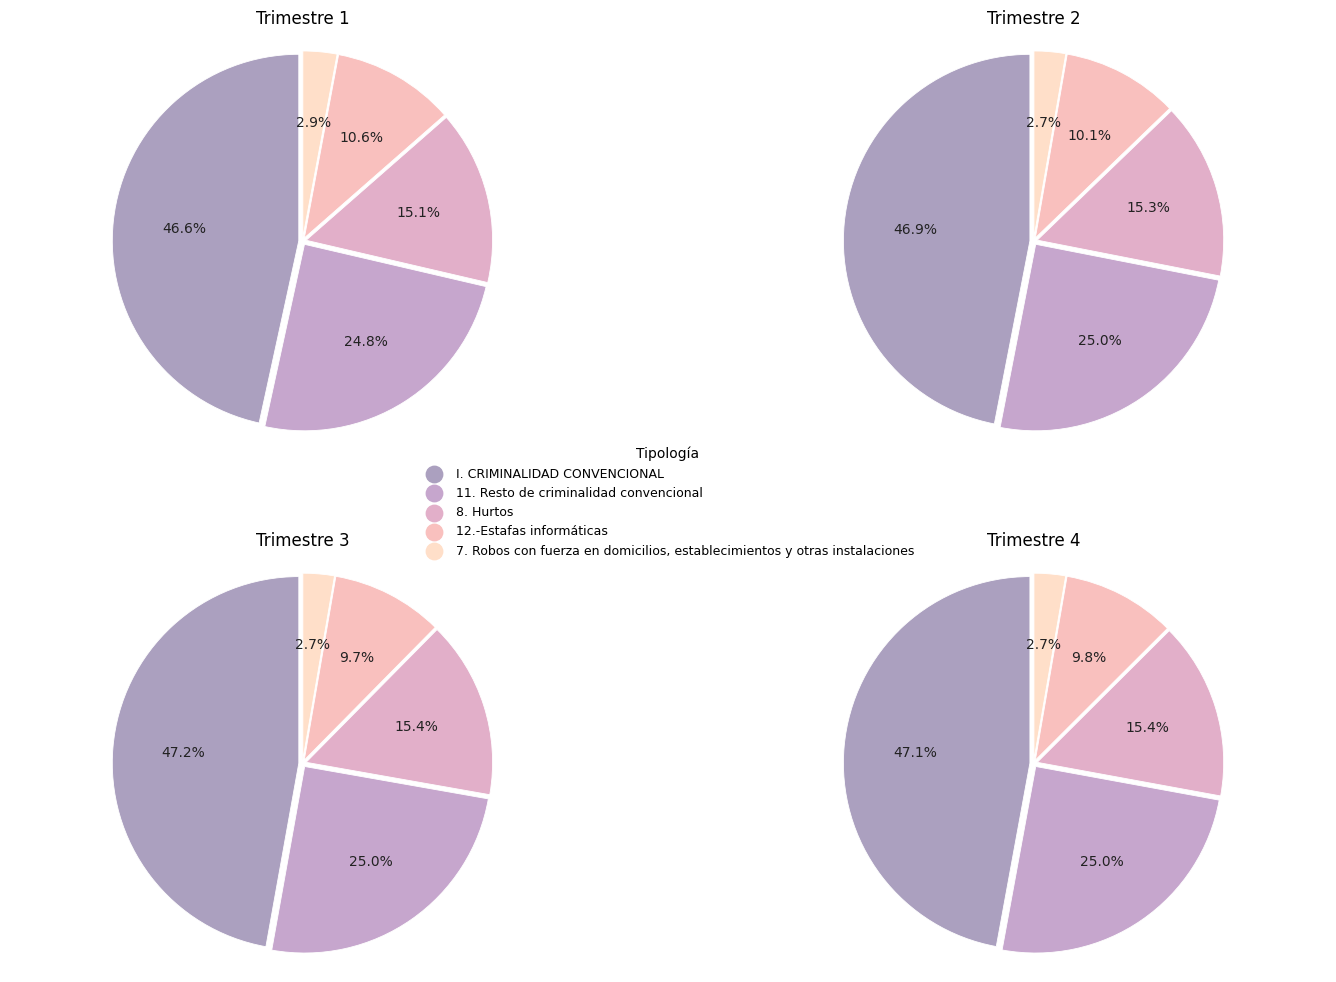

In [69]:
def _lighten(color, amount=0.6):
    # si ya es RGB en floats (seaborn palette devuelve esto)
    if isinstance(color, (tuple, list)) and len(color) >= 3:
        r, g, b = float(color[0]), float(color[1]), float(color[2])
    else:
        s = str(color).strip()
        # hex #RRGGBB
        if s.startswith('#') and len(s) == 7:
            try:
                r = int(s[1:3], 16) / 255.0
                g = int(s[3:5], 16) / 255.0
                b = int(s[5:7], 16) / 255.0
            except Exception:
                r = g = b = 0.466  # fallback gris
        else:
            # fallback para nombres no reconocidos
            r = g = b = 0.466

    return (r + (1 - r) * amount, g + (1 - g) * amount, b + (1 - b) * amount)
top_n = 5

# detectar columna de tipología
tip_col = 'tipologa_penal' if 'tipologa_penal' in df_all.columns else next(
    (c for c in df_all.columns if any(k in c.lower() for k in ('tipol', 'delit', 'delito', 'homic'))),
    None,
)
if tip_col is None:
    raise KeyError("No se encontró columna de tipología penal (ej.: 'tipologa_penal').")

# asegurar 'total' numérico
df_all['total'] = pd.to_numeric(
    df_all['total'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False),
    errors='coerce'
)

# trimestres ordenados (máx. 4)
trimestres = sorted(df_all['trimestre'].dropna().unique())[:4]

# recolectar top labels por trimestre (mantener orden de aparición)
tops = {}
seen = {}
for t in trimestres:
    d = df_all[df_all['trimestre'] == t].copy()
    mask = ~d[tip_col].astype(str).str.lower().str.contains(r'\btotal\b|infracc|infracciones?', na=False)
    d = d[mask]
    top = d.groupby(tip_col)['total'].sum().nlargest(top_n)
    tops[t] = top
    for lab in top.index:
        if lab not in seen:
            seen[lab] = None
union_labels = list(seen.keys())

# paleta y mapa de colores (base)
palette = sns.color_palette('magma', n_colors=max(len(union_labels), 5))
color_map = {lab: palette[i % len(palette)] for i, lab in enumerate(union_labels)}

# figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, t in enumerate(trimestres):
    ax = axes[i]
    top = tops.get(t, pd.Series(dtype=float))
    if top.empty or top.sum() == 0:
        ax.text(0.5, 0.5, 'Sin datos', ha='center', va='center')
        ax.set_title(f'Trimestre {t}')
        ax.axis('off')
        continue

    labels = top.index.tolist()
    sizes = top.values
    # colores aclarados por porción
    colors = [_lighten(color_map.get(l, '#777777'), amount=0.6) for l in labels]
    explode = [0.02] * len(labels)

    # mostrar SOLO el porcentaje dentro del "queso"
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=None,
        colors=colors,
        explode=explode,
        autopct=lambda pct: f"{pct:.1f}%",
        startangle=90,
        pctdistance=0.62,
        wedgeprops=dict(edgecolor='w', linewidth=0.6)
    )

    # formato de porcentajes
    for at in autotexts:
        at.set_fontsize(10)
        at.set_color('#222222')

    ax.set_title(f'Trimestre {t}')
    ax.axis('equal')

# desactivar ejes sobrantes si hay menos de 4 trimestres
for j in range(len(trimestres), len(axes)):
    axes[j].axis('off')

# leyenda centrada con solo nombres
handles = []
labels = [str(l) for l in union_labels]
for l in union_labels:
    col = _lighten(color_map.get(l, '#777777'), amount=0.6)
    # scatter con datos vacíos devuelve un PathCollection válido para la leyenda
    h = axes[0].scatter([], [], s=140, c=[col], marker='o')
    handles.append(h)

fig.legend(
    handles=handles,
    labels=labels,
    title='Tipología',
    loc='center',
    bbox_to_anchor=(0.5, 0.5),
    frameon=False,
    fontsize=9,
)
plt.subplots_adjust(left=0.03, right=0.97, top=0.97, bottom=0.03, wspace=0.25, hspace=0.25)
plt.show()

La criminalidad convencional es la más frecuente en todos los trimestres.

2. Top 5 comunidades autónomas con más delitos por trimestre

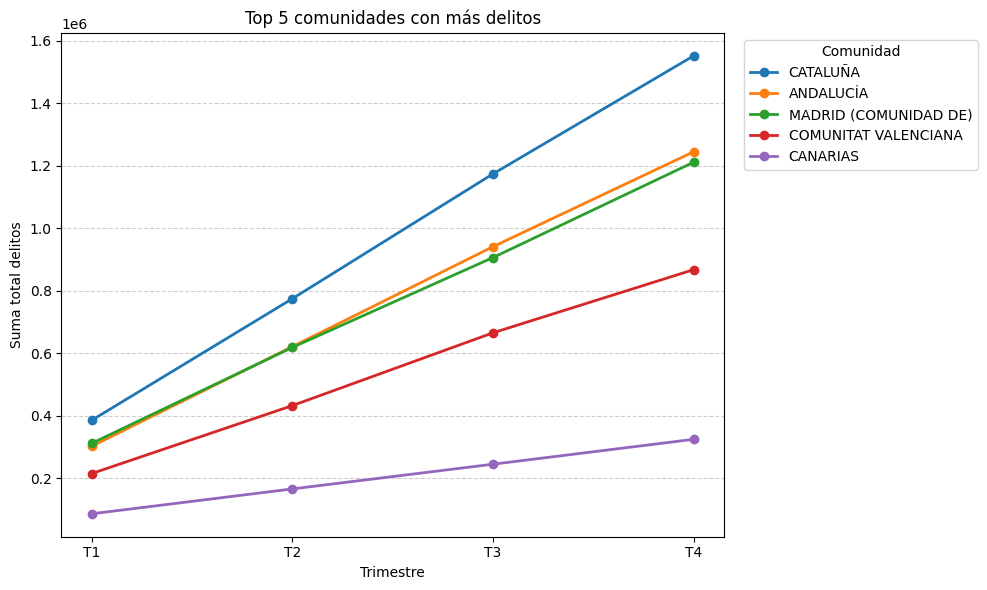

In [78]:
top_n = 5

# detectar columna de comunidad/autónoma
com_cols = [c for c in df_all.columns if any(k in c.lower() for k in ('comunid', 'auton', 'ccaa', 'comunidad'))]
if not com_cols:
    raise KeyError("No se encontró columna de comunidad/autonoma en df_all. Define 'com_col' manualmente.")
com_col = 'comunidades_autnomas' if 'comunidades_autnomas' in df_all.columns else com_cols[0]

# asegurar 'total' numérico
df_all['total'] = pd.to_numeric(
    df_all['total'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False).str.strip(),
    errors='coerce'
)

# excluir filas agregadas - CAMBIO: usar df_all, crear df_reg
pat_agreg = r'\b(?:total nacional|en el extranjero)\b'
df_reg = df_all[~df_all[com_col].astype(str).str.lower().str.contains(pat_agreg, na=False)].copy()

# pivot: filas = trimestre, columnas = comunidad, valores = suma total
pivot = df_reg.groupby(['trimestre', com_col])['total'].sum().unstack(fill_value=0)

# elegir Top N comunidades por suma total acumulada
top_coms = pivot.sum(axis=0).nlargest(top_n).index.tolist()
plot_data = pivot[top_coms]

# asegurar orden de trimestres (índice numérico)
plot_data = plot_data.sort_index()

# plot de líneas
fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('tab10', n_colors=len(plot_data.columns))
for i, col in enumerate(plot_data.columns):
    ax.plot(plot_data.index, plot_data[col], marker='o', label=col, color=colors[i], linewidth=2)

ax.set_xticks(plot_data.index)
ax.set_xticklabels([f"T{int(x)}" for x in plot_data.index])
ax.set_title(f"Top {top_n} comunidades con más delitos")
ax.set_xlabel("Trimestre")
ax.set_ylabel("Suma total delitos")
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(title='Comunidad', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

Cataluña, Andalucía, Madrid, Comunidad Valenciana y Canarias.

3. ¿Qué comunidades tuvieron más homicidios y asesinatos?

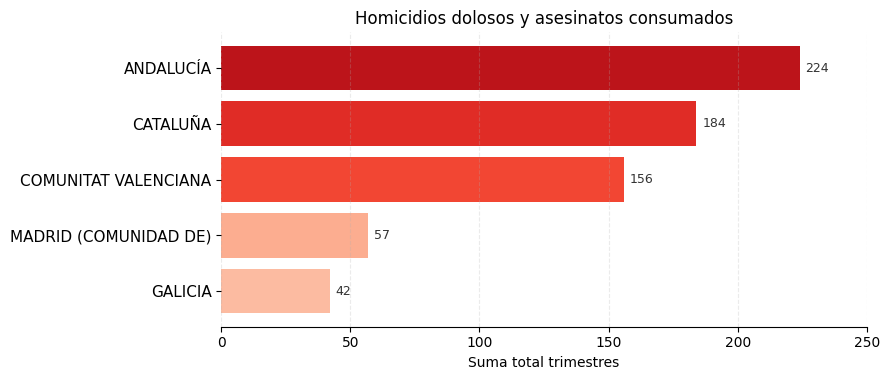

In [72]:
# detectar columnas
com_col = next((c for c in df_all.columns if any(k in c.lower() for k in ('comunid', 'auton', 'ccaa', 'comunidad'))), None)
tip_col = next((c for c in df_all.columns if any(k in c.lower() for k in ('tipol', 'tipolog', 'tipologia', 'tipología', 'delito', 'delit', 'homic'))), None)
if com_col is None or tip_col is None:
    raise KeyError("No se encontró columna de comunidad o tipología en df_all.")

# asegurar 'total' numérico y filtrar homicidios
df_all['total'] = pd.to_numeric(
    df_all['total'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False).str.strip(),
    errors='coerce'
).fillna(0)

mask_tip = df_all[tip_col].astype(str).str.contains('homicidios dolosos y asesinatos consumados', case=False, na=False)
if mask_tip.sum() == 0:
    mask_tip = df_all[tip_col].astype(str).str.contains(r'homicid|asesin', case=False, na=False)
df_h = df_all[mask_tip].copy()

# excluir filas
pat_agreg = r'\b(?:total nacional|en el extranjero)\b'
df_h = df_h[~df_h[com_col].astype(str).str.lower().str.contains(pat_agreg, na=False)].copy()

# top5 por suma acumulada
totales = df_h.groupby(com_col)['total'].sum().sort_values(ascending=False)
top5 = totales.head(5)

if top5.empty:
    print("No hay datos para Top5")
else:
    names = top5.index.tolist()
    values = top5.values.astype(float)

    cmap = plt.get_cmap('Reds')

    # normalizar manualmente y mapear a un rango suave (0.25 - 0.8)
    vals = np.asarray(values, dtype=float)
    vmin, vmax = vals.min(), vals.max()
    if vmax > vmin:
        norm_vals = (vals - vmin) / (vmax - vmin)
    else:
        norm_vals = np.zeros_like(vals, dtype=float)
    p_vals = 0.25 + 0.55 * norm_vals   # valores pequeños -> más claros, grandes -> más oscuros
    colors_list = [cmap(float(p)) for p in p_vals]
    
    # gráfico
    fig, ax = plt.subplots(figsize=(9, 0.9 + 0.6 * len(names)))
    y = np.arange(len(names))
    ax.barh(y, values, color=colors_list, edgecolor='none')
    ax.set_yticks(y)
    ax.set_yticklabels(names, fontsize=11)
    ax.invert_yaxis()
    ax.set_title("Homicidios dolosos y asesinatos consumados", fontsize=12)
    ax.set_xlabel("Suma total trimestres")

    # formatear eje x (miles con punto)
    fig.canvas.draw()
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{int(round(x)):,}".replace(",", ".") for x in xticks])

    # anotaciones finales a la derecha de las barras
    vmax = values.max() if len(values) else 0
    offset = vmax * 0.01 if vmax > 0 else 1
    for i, v in enumerate(values):
        ax.text(v + offset, y[i], f"{int(round(v)):,}".replace(",", "."), va='center', fontsize=9, color='#333333')

    # estética
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)
    ax.grid(axis='x', linestyle='--', alpha=0.25)

    plt.tight_layout()
    plt.show()

Andalucía, Cataluña, Comunidad Valenciana, Madrid y Galicia.

4. ¿En qué periodos se concentran más delitos por trimestre?

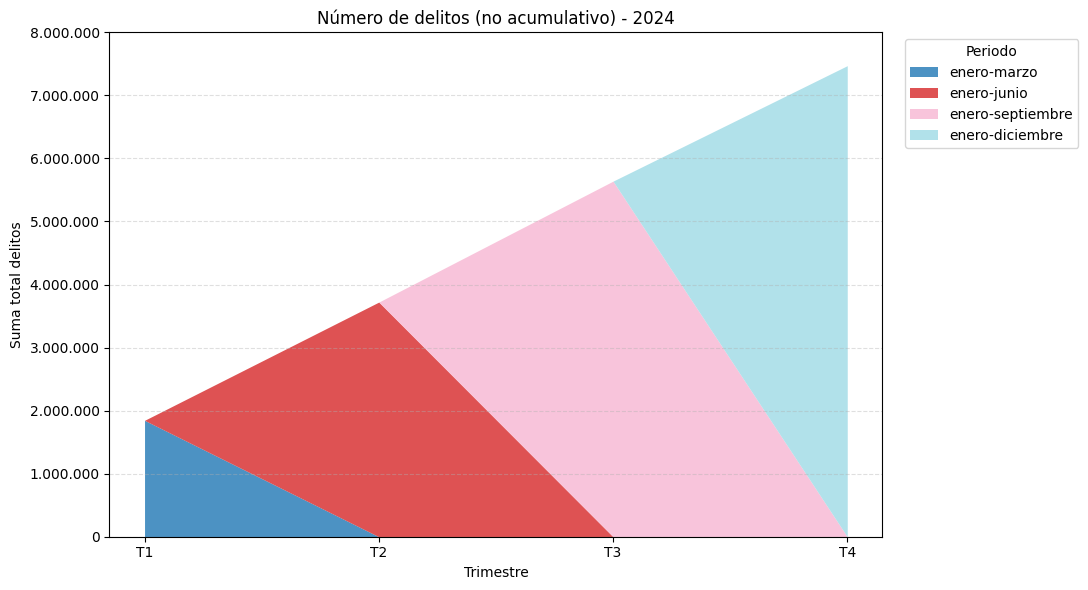

In [73]:
period_col = 'periodos' if 'periodos' in df_all.columns else next((c for c in df_all.columns if 'period' in c.lower()), None)
if period_col is None:
    raise KeyError("No se encontró columna de periodos en df_all.")

# asegurar total numérico y excluir filas agregadas / filas de variación %
df_all['total'] = pd.to_numeric(
    df_all['total'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False).str.strip(),
    errors='coerce'
)
pat_agreg = r'\b(?:total|nacional)\b'
com_col_guess = next((c for c in df_all.columns if any(k in c.lower() for k in ('comunid', 'auton', 'ccaa', 'comunidad'))), None)
mask_agreg = df_all[com_col_guess].astype(str).str.lower().str.contains(pat_agreg, na=False) if com_col_guess is not None else False
mask_vari = df_all[period_col].astype(str).str.lower().str.contains(r'variaci', na=False)
df_reg = df_all[~mask_agreg & ~mask_vari].copy()

# filtrar solo 2024 y limpiar sufijo año
df_reg = df_reg[df_reg[period_col].astype(str).str.contains('2024', na=False)].copy()
df_reg[period_col] = df_reg[period_col].astype(str).str.replace(r'\s*2024$', '', regex=True).str.strip()

# Agregar por trimestre y periodo
gp = df_reg.groupby(['trimestre', period_col])['total'].sum().reset_index()

# Pivot: filas=trimestre, columnas=periodo
pivot = gp.pivot(index='trimestre', columns=period_col, values='total').fillna(0)
if pivot.empty:
    print("No hay datos para mostrar por periodos y trimestres.")
else:
    # ordenar trimestres (si son números)
    try:
        pivot = pivot.sort_index()
    except Exception:
        pass

    # Convertir periodos acumulativos a no acumulativos (enero-marzo, enero-junio, ...)
    mapping = {
        'enero-marzo': 1,
        'enero-junio': 2,
        'enero-septiembre': 3,
        'enero-diciembre': 4,
    }
    cols = list(pivot.columns.astype(str))
    try:
        ordered = sorted(cols, key=lambda c: mapping.get(c.lower(), cols.index(c)))
    except Exception:
        ordered = cols

    pivot = pivot.astype(float).fillna(0)

    non_cum = pd.DataFrame(index=pivot.index)
    for i, col in enumerate(ordered):
        if i == 0:
            non_cum[col] = pivot[col]
        else:
            non_cum[col] = pivot[col] - pivot[ordered[i - 1]]
    # Evitar negativos por artefactos
    non_cum = non_cum.clip(lower=0)

    # Plot: áreas no acumulativas apiladas
    fig, ax = plt.subplots(figsize=(11, 6))
    non_cum.plot(kind='area', ax=ax, stacked=True, colormap='tab20', alpha=0.8, linewidth=0)

    ax.set_title("Número de delitos (no acumulativo) - 2024")
    ax.set_xlabel("Trimestre")
    ax.set_ylabel("Suma total delitos")

    fig.canvas.draw()
    yticks = ax.get_yticks()
    try:
        ylabels = [f"{int(round(y)):,}".replace(',', '.') for y in yticks]
    except Exception:
        ylabels = [str(int(y)) for y in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)

    ax.legend(title='Periodo', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_xticks(non_cum.index)
    ax.set_xticklabels([f"T{int(x)}" for x in non_cum.index])
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

En enero-diciembre del trimestre 4.